In [6]:
import numpy as np
import spikeinterface
import spikeinterface.full as si
import spikeinterface.extractors as se
import h5py
import matplotlib.pyplot as plt

from helper_functions import detect_peaks
import pandas as pd
import time
from multiprocessing import Pool

import helper_functions as helper

# SpikeInterface H5 Data Extraction

In [155]:
class StimulationAnalysis:
    def __init__(self, file_path, recording_electrode=None, stim_electrode=None, artifact_electrode=None):
        self.file_path = file_path
        self.rec_electrode = recording_electrode
        self.stim_electrode = stim_electrode
        self.artifact_electrode = artifact_electrode
        self.channel_list = []
        if self.rec_electrode is not None:
            self.get_channel_id('recording')
        if self.stim_electrode is not None:
            self.get_channel_id('stim')
        if self.artifact_electrode is not None:
            self.get_channel_id('artifact')
        
        self.recording = se.read_maxwell(self.file_path)
        self.recording_bp = si.bandpass_filter(self.recording, freq_min=300, freq_max=3000)

        self.channel_ids = self.recording.get_channel_ids()
        self.fs = self.recording.get_sampling_frequency()
        self.num_chan = self.recording.get_num_channels()
        self.num_seg = self.recording.get_num_segments()
        self.num_samples = self.recording.get_num_samples(segment_index=0)
        self.total_recording = self.recording.get_total_duration()

    def print_file_structure(self):
        with h5py.File(self.file_path, 'r') as h5file:
            def print_hdf5_structure(name, obj):
                print(name)

            h5file.visititems(print_hdf5_structure)

    def plot_neuron_print(self):
        fig, ax = plt.subplots(figsize=(8,8))
        si.plot_probe_map(self.recording_bp, ax=ax, with_channel_ids=False)
        ax.invert_yaxis()

        return

    def get_channel_id(self, electrode_type):
        # get the corresponding channel ID of an electrode 
        # electrode_type = 'stim', 'recording', 'artifact' 
    
        with h5py.File(self.file_path, 'r') as h5file:

            mapping = h5file['data_store/data0000/settings/mapping']

            if electrode_type == 'stim':
                electrode_id = self.stim_electrode
                self.stim_channel = [entry for entry in mapping if entry[1] == electrode_id][0][0]

                self.channel_list.append(self.stim_channel)
            elif electrode_type == 'recording':
                electrode_id = self.rec_electrode
                self.rec_channel = [entry for entry in mapping if entry[1] == electrode_id][0][0]

                self.channel_list.append(self.rec_channel)
            elif electrode_type == 'artifact':
                electrode_id = self.artifact_electrode
                self.artifact_channel = [entry for entry in mapping if entry[1] == electrode_id][0][0]

                self.channel_list.append(self.artifact_channel)
            else:
                raise ValueError("Invalid input parameter for electrode_type, must be 'stim', 'recording', or 'artifact'.")



    def get_channel_ids(self, reading_electrode, stim_electrode, artifact_electrode):
        self.rec_electrode = reading_electrode
        self.stim_electrode = stim_electrode
        self.artifact_electrode = artifact_electrode
        with h5py.File(self.file_path, 'r') as h5file:
            mapping = h5file['data_store/data0000/settings/mapping']

            self.rec_channel = [entry for entry in mapping if entry[1] == reading_electrode][0][0]
            self.stim_channel = [entry for entry in mapping if entry[1] == stim_electrode][0][0]
            self.artifact_channel = [entry for entry in mapping if entry[1] == artifact_electrode][0][0]

            self.channel_list = [self.rec_channel, self.stim_channel, self.artifact_channel]

    def process_batch(self, time_range):
            start_frame, end_frame = time_range

            try:
                #print(f"Processing frames {start_frame} to {end_frame}")

                # Retrieve batch of data
                traces = self.recording_bp.get_traces(start_frame=start_frame, end_frame=end_frame, segment_index=0, return_scaled=False)

                # Collect peaks for each channel in this batch
                batch_peaks = {'Time Range': f"{start_frame} to {end_frame}"}
                for channel in self.channel_list:
                    channel_indices = np.where(self.channel_ids == str(channel))[0]

                    channel_index = channel_indices[0]

                    x, y = detect_peaks(traces[:, channel_index], peak_sign="neg", abs_threshold=9)
                    batch_peaks[f'Channel {channel}'] = len(x)

                return batch_peaks

            except ValueError as e:
                print(f"Skipping range {start_frame} to {end_frame} due to error: {e}")
                return None # Skip this batch if an error occurs

    def get_spike_counts(self):
        # Returns dataframe with spike counts for stim and recording electrodes

        start_time = 0
        end_time = self.num_samples / self.fs

        batch_size = int(self.fs * 10)
        total_frames = int((end_time - start_time)*self.fs)

        # Prepare time ranges 
        time_ranges = [(start, min(start + batch_size, total_frames)) for start in range(0, total_frames, batch_size) if start + batch_size <= total_frames] 
        
        # Use multiprocessing to process batches in parallel 
        with Pool(16) as pool: 
            results = pool.map(self.process_batch, time_ranges) 

        # Filter out None results and extract valid results 
        valid_results = [result for result in results if result is not None] 

        self.peak_counts_df = pd.DataFrame(valid_results) 

        return self.peak_counts_df

    def plot_spike_counts_bar_graph(self, electrode_type, trial_no):
        # electrode_type: 'stim', 'recording', 'artifact'

        # Convert 'Time Range' from samples to seconds by dividing by the sample frequency
        time_values = pd.Series([int(time.split(' ')[0]) / self.fs for time in self.peak_counts_df['Time Range']])

        total_time_range = max(time_values) - min(time_values)
        first_third = min(time_values) + total_time_range / 3
        second_third = min(time_values) + 2 * total_time_range / 3

        # Select the spike counts based on the electrode type
        if electrode_type == 'recording':
            spike_counts = self.peak_counts_df[f'Channel {self.rec_channel}']
        elif electrode_type == 'stim':
            spike_counts = self.peak_counts_df[f'Channel {self.stim_channel}']
        elif electrode_type == 'artifact':
            spike_counts = self.peak_counts_df[f'Channel {self.artifact_channel}']
        else: 
            raise ValueError("Invalid input parameter for plot_spike_counts(). electrode_type must be 'stim', 'recording', or 'artifact'" )        

        # Plot the bar graph for each batch (each bar corresponds to a batch)
        plt.figure(figsize=(10, 6))

        # Plot the bars with time_values as the x-axis and spike_counts as the y-axis
        plt.bar(time_values, spike_counts, width=(time_values.iloc[1] - time_values.iloc[0]), color='b')

        # Add labels and title
        plt.title(f'Spike Counts per Batch for Trial {trial_no} - {electrode_type.capitalize()} Electrode')
        plt.xlabel('Time (seconds)')
        plt.ylabel('Spike Count per Batch')
        plt.axvline(x=first_third, color='g', linestyle='--')
        plt.axvline(x=second_third, color='g', linestyle='--')

        # Display the plot
        plt.show()


    def plot_spike_counts(self, electrode_type, trial_no):
        # electrode_type: 'stim', 'recording', 'artifact'

        # convert time values to seconds by dividing by sample frequency
        time_values = pd.Series([int(time.split(' ')[0]) / self.fs for time in self.peak_counts_df['Time Range']]) 
            
        total_time_range = max(time_values) - min(time_values)
        first_third = min(time_values) + total_time_range / 3
        second_third = min(time_values) + 2 * total_time_range / 3

        if electrode_type == 'recording':
            spike_counts = self.peak_counts_df[f'Channel {self.rec_channel}']
        elif electrode_type == 'stim':
            spike_counts = self.peak_counts_df[f'Channel {self.stim_channel}']
        elif electrode_type == 'artifact':
            spike_counts = self.peak_counts_df[f'Channel {self.artifact_channel}']
        else:
            raise ValueError("Invalid input parameter for plot_spike_counts(). electrode_type must be 'stim', 'recording', or 'artifact'" )

        # Calculate spike counts for each third 
        first_third_spike_count = spike_counts[time_values <= first_third].sum() 
        second_third_spike_count = spike_counts[(time_values > first_third) & (time_values <= second_third)].sum() 
        third_third_spike_count = spike_counts[time_values > second_third].sum() 
        
        # Print the total spike count for each third 
        print(f"Pre-stim total spike count: {first_third_spike_count}") 
        print(f"Stim total spike count: {second_third_spike_count}") 
        print(f"Post-stim spike count: {third_third_spike_count}") 


        plt.figure(figsize=(10,6))
        plt.plot(time_values, spike_counts, marker='o', linestyle='-', color='b')

        plt.axvline(x=first_third, color='g', linestyle='--')
        plt.axvline(x=second_third, color='g', linestyle='--')


        plt.title(f'Spike Counts Over Time - Trial {trial_no} {electrode_type.capitalize()} Electrode')
        plt.xlabel('Time (in samples)')
        plt.ylabel('Spike Count')
        plt.grid(True)

        plt.show()

    def plot_individual_traces(self, electrode_type, trial_no, bp_filter=True, time_range=None, start_at=0):
        # electrode_type: 'Stim', 'recording', 'artifact'
        # time_range: number of seconds to show on x-axis (smaller value is more zoomed in)
        #             --> default is entire stim phase (60 seconds)

        if time_range is None:
            time_range = self.total_recording / 3

        if electrode_type.lower() == 'stim':
            channel = str(self.stim_channel)
        elif electrode_type.lower() == 'recording':
            channel = str(self.rec_channel)
        elif electrode_type.lower() == 'artifact':
            channel = str(self.artifact_channel)
        else:
            raise ValueError()
    
        if bp_filter:
            recording_data = self.recording_bp
        else:
            recording_data = self.recording

        chunk_duration = self.total_recording / 3

        samples_per_chunk = int(chunk_duration * self.fs)

        pre_stim_start = 0
        pre_stim_end = samples_per_chunk
        pre_stim_data = recording_data.get_traces(channel_ids=[channel], start_frame=pre_stim_start, end_frame=pre_stim_end)

        during_stim_start = pre_stim_end 
        during_stim_end = pre_stim_end + samples_per_chunk 
        during_stim_data = recording_data.get_traces(channel_ids=[channel], start_frame=during_stim_start, end_frame=during_stim_end) 

        post_stim_start = during_stim_end 
        post_stim_end = self.num_samples 
        post_stim_data = recording_data.get_traces(channel_ids=[channel], start_frame=post_stim_start, end_frame=post_stim_end) 

        time_pre_stim = np.arange(0, len(pre_stim_data)) / self.fs
        time_during_stim = np.arange(0, len(during_stim_data)) / self.fs
        time_post_stim = np.arange(0, len(post_stim_data)) / self.fs

        plt.figure()
        plt.plot(time_pre_stim, pre_stim_data)
        plt.xlabel('Time (S)')
        plt.ylabel('Amplitude')
        plt.title(f'{electrode_type.capitalize()} Electrode Pre-Stim Trace Trial {trial_no}')
        plt.xlim(start_at, start_at + time_range)
        plt.show()

        plt.figure()
        plt.plot(time_during_stim, during_stim_data)
        plt.xlabel('Time (S)')
        plt.ylabel('Amplitude')
        plt.title(f'{electrode_type.capitalize()} Electrode During-Stim Trace Trial {trial_no}')
        plt.xlim(start_at, start_at + time_range)
        
        # Add stim lines
        for x in np.arange(start_at, start_at + time_range, 0.25):
            plt.axvline(x=x, color='r', linestyle=':', linewidth = 1)

        plt.show()

        plt.figure()
        plt.plot(time_post_stim, post_stim_data)
        plt.xlabel('Time (S)')
        plt.ylabel('Amplitude')
        plt.title(f'{electrode_type.capitalize()} Electrode Post-Stim Trace Trial {trial_no}')
        plt.xlim(start_at, start_at + time_range)
        plt.show()
        

    def plot_stim_traces(self, trial_no, bp_filter=True, time_range=None, start_at=0):
        if time_range is None:
            time_range = self.total_recording / 3

        if bp_filter:
            recording_data = self.recording_bp
        else:
            recording_data = self.recording

        chunk_duration = self.total_recording / 3

        samples_per_chunk = int(chunk_duration * self.fs)

        pre_stim_start = 0
        pre_stim_end = samples_per_chunk

        stim_start = samples_per_chunk 
        stim_end = stim_start + samples_per_chunk 
        stim_data = recording_data.get_traces(
            channel_ids=[str(channel) for channel in self.channel_list], 
            start_frame=stim_start, 
            end_frame=stim_end
        ) 

        print(stim_data)
        print(stim_data[:,1])

        time_during_stim = np.arange(0, len(stim_data)) / self.fs

        fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True)

        ax1.plot(time_during_stim, stim_data[:,1], 'b-')
        ax1.set_ylabel('Stim ')
        ax1.set_title(f'Trial {trial_no} Traces')

        ax3.plot(time_during_stim, stim_data[:,0], 'b-')
        ax3.set_ylabel('Recording')
        ax3.set_xlabel('Time (s)')

        ax2.plot(time_during_stim, stim_data[:,2], 'b-')
        ax2.set_ylabel('Artifact ')

        plt.xlim(start_at, start_at + time_range)

        plt.show()
    


In [160]:
def full_analysis(file_path, trial_no, recording_electrode, stim_electrode, artifact_electrode=None):
    trial_data = StimulationAnalysis(file_path=file_path, recording_electrode=recording_electrode, stim_electrode=stim_electrode, artifact_electrode=artifact_electrode)

    trial_data.plot_neuron_print()

    trial_data.plot_individual_traces('recording', trial_no, bp_filter=True)
    trial_data.plot_individual_traces('stim', trial_no, bp_filter=True)
    if artifact_electrode is not None:
        trial_data.plot_individual_traces('artifact', trial_no, bp_filter=True, time_range=0.5)

    trial_data.get_spike_counts()
    trial_data.plot_spike_counts_bar_graph('recording', trial_no)
    trial_data.plot_spike_counts_bar_graph('stim', trial_no)
    if artifact_electrode is not None:
        trial_data.plot_spike_counts_bar_graph('artifact', trial_no)

    trial_data.plot_stim_traces(trial_no)

    return trial_data

# Trial 4 

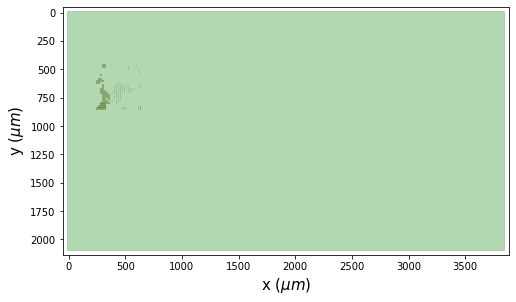

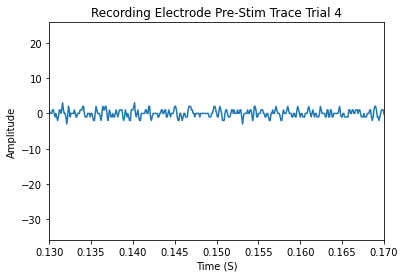

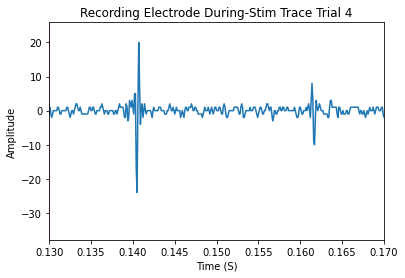

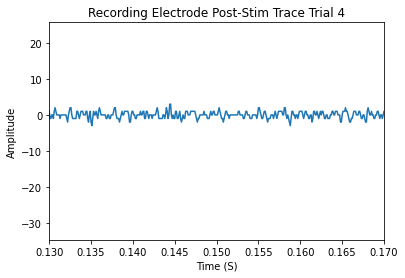

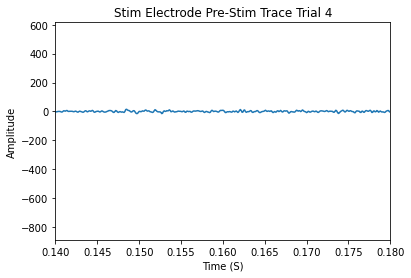

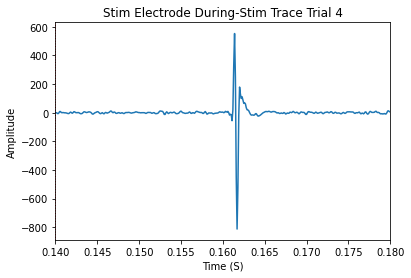

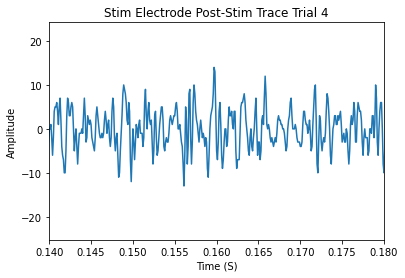

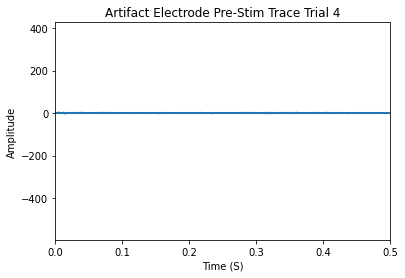

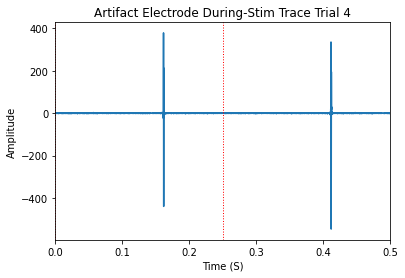

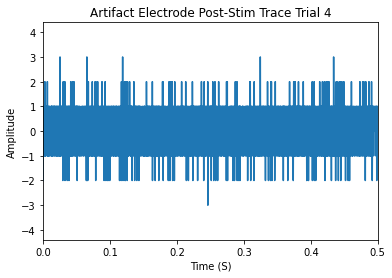

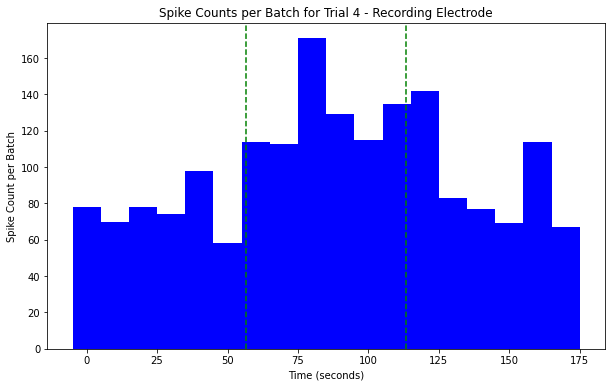

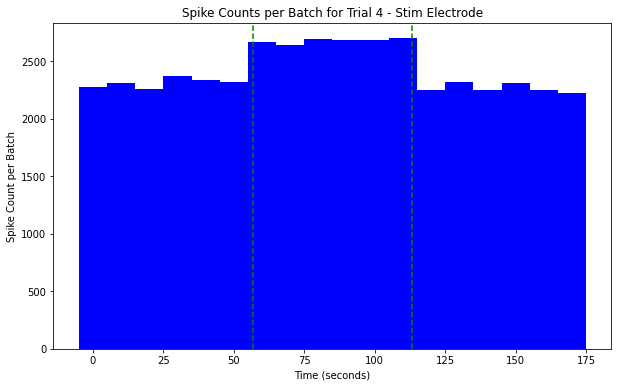

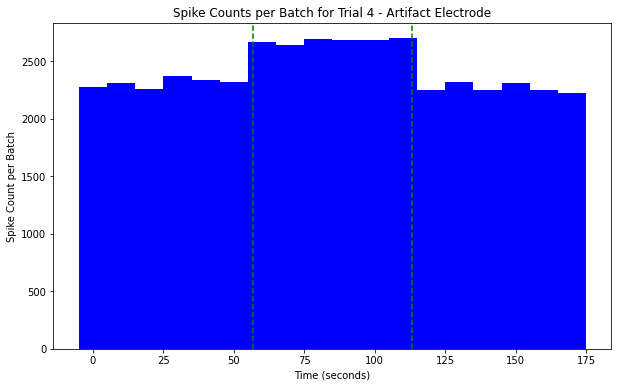

In [128]:
fp = '/mnt/disk15tb/nathaniel/000189/data.raw.h5'
trial4_data = full_analysis(fp, trial_no=4, recording_electrode=8165, stim_electrode=8157, artifact_electrode=7937)


[[1 6 1]
 [2 8 1]
 [1 7 0]
 ...
 [2 7 1]
 [2 7 2]
 [4 2 0]]
[6 8 7 ... 7 7 2]


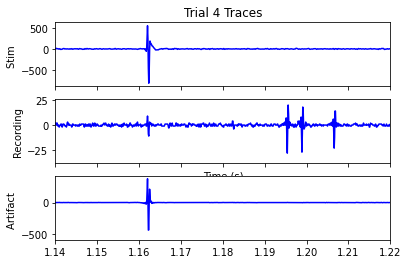

In [125]:

fp = '/mnt/disk15tb/nathaniel/000189/data.raw.h5'
trial4_data = StimulationAnalysis(fp, recording_electrode=8165, stim_electrode=8157, artifact_electrode=7937)
trial4_data.plot_stim_traces(4, time_range=0.08, start_at=1.14)

# with h5py.File(fp, 'r') as h5file:

#     stim_times = h5file['assay/inputs/pulse_trains']

#     print(stim_times[:])



# Trial 3

[[ 2  2  1]
 [ 2  5  0]
 [ 1  3 -1]
 ...
 [-1 -1  0]
 [-1 -1 -1]
 [-1  1 -1]]
[ 2  5  3 ... -1 -1  1]


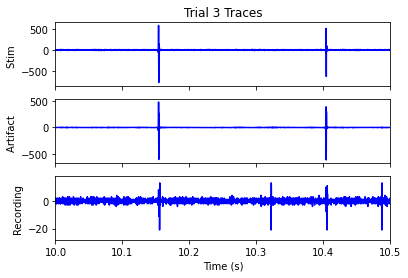

Pre-stim total spike count: 537
Stim total spike count: 747
Post-stim spike count: 467


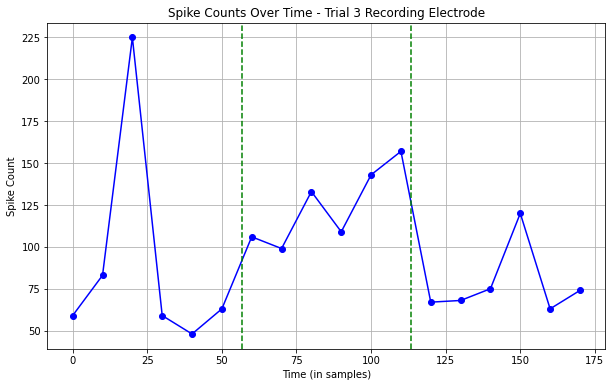

Pre-stim total spike count: 11059
Stim total spike count: 17870
Post-stim spike count: 11215


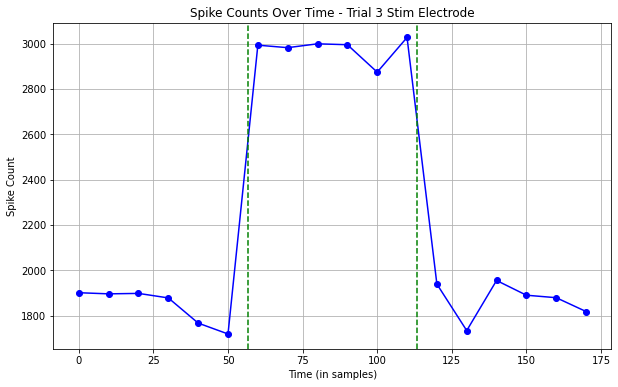

Pre-stim total spike count: 11059
Stim total spike count: 17870
Post-stim spike count: 11215


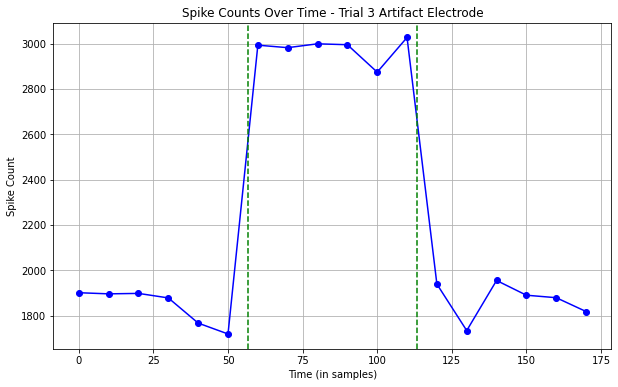

In [140]:
fp = '/mnt/disk15tb/nathaniel/000185/data.raw.h5'
trial3_data = StimulationAnalysis(file_path=fp, recording_electrode=8165, stim_electrode=9925, artifact_electrode=9924)

trial3_data.plot_stim_traces(3, time_range=0.5, start_at=10)

trial3_data.get_spike_counts()

trial3_data.plot_spike_counts('recording', 3)
trial3_data.plot_spike_counts('stim', 3)
trial3_data.plot_spike_counts('artifact', 3)

Pre-stim total spike count: 537
Stim total spike count: 747
Post-stim spike count: 467


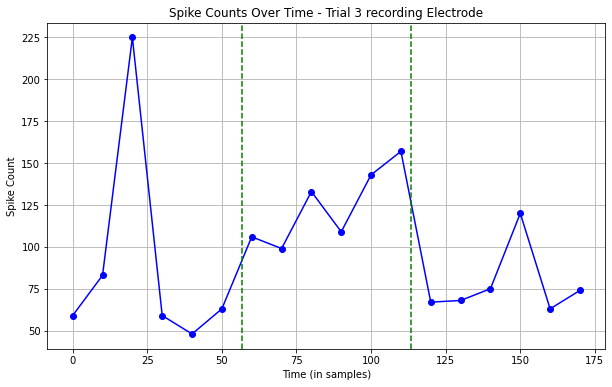

Pre-stim total spike count: 11059
Stim total spike count: 17870
Post-stim spike count: 11215


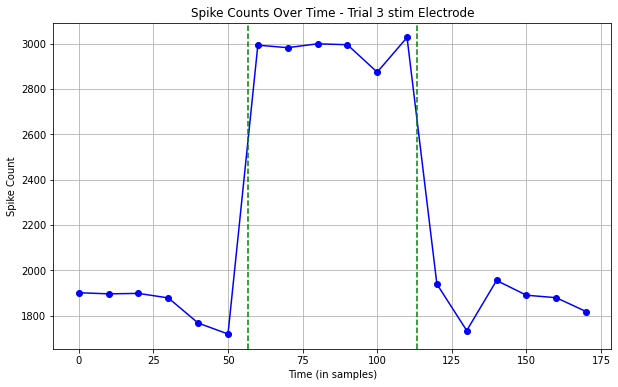

In [82]:
trial3_data.plot_spike_counts('recording', 3)
trial3_data.plot_spike_counts('stim', 3)

# Trial 2

536
532
Processing frames 100000 to 200000Processing frames 400000 to 500000Processing frames 700000 to 800000Processing frames 200000 to 300000Processing frames 0 to 100000Processing frames 500000 to 600000Processing frames 600000 to 700000Processing frames 900000 to 1000000Processing frames 300000 to 400000Processing frames 800000 to 900000

Processing frames 1100000 to 1200000
Processing frames 1000000 to 1100000
Processing frames 1300000 to 1400000
Processing frames 1500000 to 1600000




Processing frames 1400000 to 1500000Processing frames 1200000 to 1300000





Processing frames 1600000 to 1700000
Processing frames 1700000 to 1800000


,Time Range,Channel 536,Channel 580
0,0 to 100000,92,3030
1,100000 to 200000,118,3117
2,200000 to 300000,65,3097
3,300000 to 400000,91,3147
4,400000 to 500000,59,3109
5,500000 to 600000,92,3083
6,600000 to 700000,143,3343
7,700000 to 800000,328,3352
8,800000 to 900000,98,3322
9,900000 to 1000000,153,3415


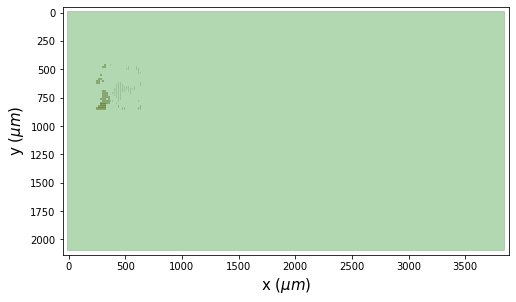

In [83]:
fp = '/mnt/disk15tb/nathaniel/000181/data.raw.h5'
trial2_data = StimulationAnalysis(file_path=fp)

trial2_data.get_channel_ids(8165,8173)
print(trial2_data.rec_channel)
print(trial3_data.stim_channel)


trial2_data.plot_neuron_print()

trial2_data.get_spike_counts()

Pre-stim total spike count: 517
Stim total spike count: 1109
Post-stim spike count: 664


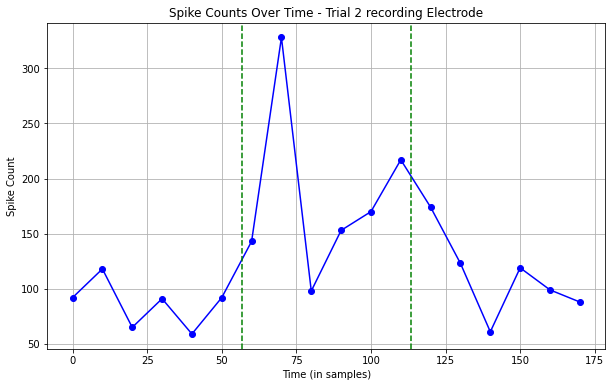

Pre-stim total spike count: 18583
Stim total spike count: 19956
Post-stim spike count: 18203


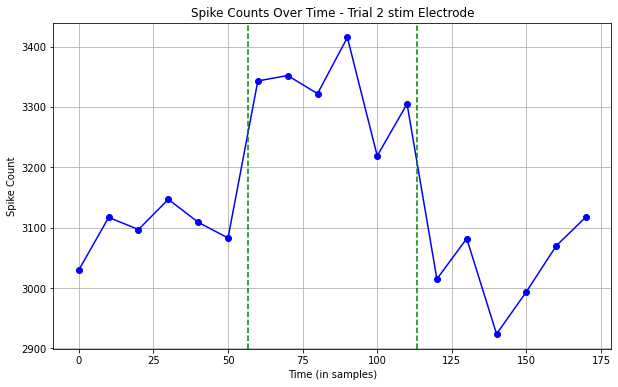

In [85]:
trial2_data.plot_spike_counts('recording',2)
trial2_data.plot_spike_counts('stim',2)

# Trial 1

Processing frames 900000 to 1000000Processing frames 700000 to 800000Processing frames 400000 to 500000Processing frames 600000 to 700000Processing frames 300000 to 400000Processing frames 500000 to 600000Processing frames 200000 to 300000Processing frames 800000 to 900000Processing frames 1100000 to 1200000Processing frames 1000000 to 1100000Processing frames 1200000 to 1300000

Processing frames 100000 to 200000Processing frames 1400000 to 1500000
Processing frames 0 to 100000Processing frames 1300000 to 1400000











Processing frames 1500000 to 1600000
Processing frames 1600000 to 1700000
Processing frames 1700000 to 1800000


,Time Range,Channel 536,Channel 468
0,0 to 100000,71,1902
1,100000 to 200000,69,1905
2,200000 to 300000,93,1872
3,300000 to 400000,88,1851
4,400000 to 500000,97,1862
5,500000 to 600000,69,1814
6,600000 to 700000,302,1913
7,700000 to 800000,130,1939
8,800000 to 900000,92,1979
9,900000 to 1000000,112,1958


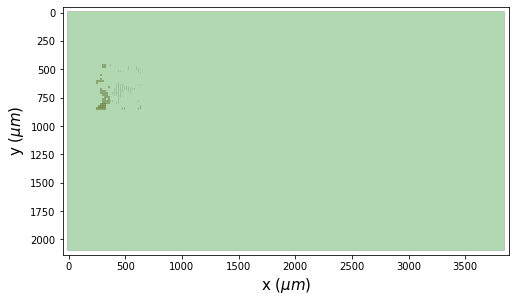

In [86]:
fp = '/mnt/disk15tb/nathaniel/000177/data.raw.h5'
trial1_data = StimulationAnalysis(file_path=fp)

trial1_data.get_channel_ids(8165,6405)

trial1_data.plot_neuron_print()

trial1_data.get_spike_counts()

Pre-stim total spike count: 487
Stim total spike count: 841
Post-stim spike count: 470


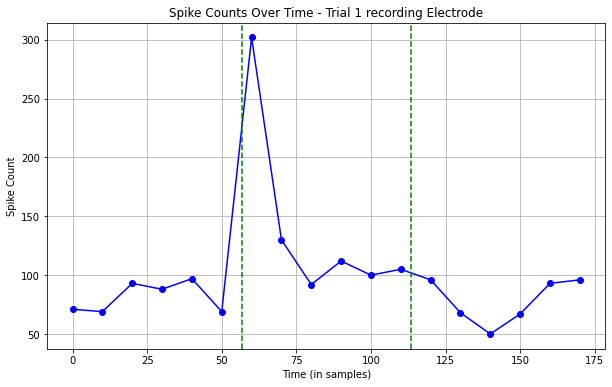

Pre-stim total spike count: 11206
Stim total spike count: 11636
Post-stim spike count: 11230


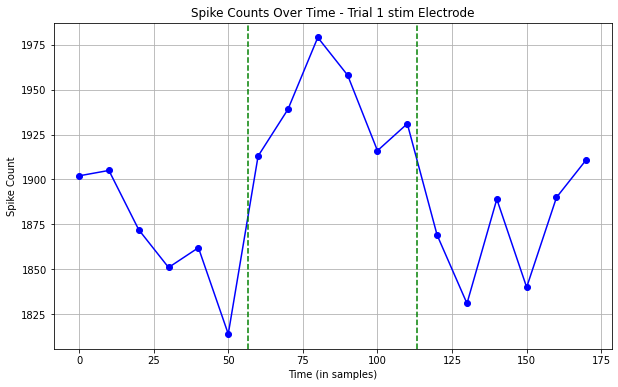

In [88]:
trial1_data.plot_spike_counts('recording', 1)
trial1_data.plot_spike_counts('stim', 1)

In [33]:
fp = '/mnt/disk15tb/nathaniel/000189/data.raw.h5'
recording = se.read_maxwell(fp)

channel_ids = recording.get_channel_ids()
fs = recording.get_sampling_frequency()
num_chan = recording.get_num_channels()
num_seg = recording.get_num_segments()
num_samples = recording.get_num_samples(segment_index=0)
total_recording = recording.get_total_duration()

start_time = 0
end_time = num_samples / fs

print('Sampling frequency:', fs)
print('No. of channels:', num_chan)
print('No. of segments:', num_seg)
print('total_recording:', total_recording)
print('No. of samples:', num_samples)
print(f'Start time: {start_time} seconds')
print(f'End time: {end_time} seconds')

recording_bp = si.bandpass_filter(recording, freq_min=300, freq_max=3000)

# Divide into three chunks: pre-stim, stim, post-stim

chunk_duration = total_recording / 3

samples_per_chunk = int(chunk_duration * fs)

pre_stim_start = 0
pre_stim_end = samples_per_chunk
pre_stim_data = recording_bp.get_traces(channel_ids=['572'], start_frame=pre_stim_start, end_frame=pre_stim_end)
print(recording_bp)
during_stim_start = pre_stim_end 
during_stim_end = pre_stim_end + samples_per_chunk 
during_stim_data = recording_bp.get_traces(channel_ids=['572'], start_frame=during_stim_start, end_frame=during_stim_end) 

post_stim_start = during_stim_end 
post_stim_end = num_samples 
post_stim_data = recording_bp.get_traces(channel_ids=['572'], start_frame=post_stim_start, end_frame=post_stim_end) 




Sampling frequency: 10000.0
No. of channels: 124
No. of segments: 1
total_recording: 182.26
No. of samples: 1822600
Start time: 0 seconds
End time: 182.26 seconds
BandpassFilterRecording: 124 channels - 10000.0Hz - 1 segments - 1,822,600 samples 
                         182.26s (3.04 minutes) - int16 dtype - 431.07 MiB


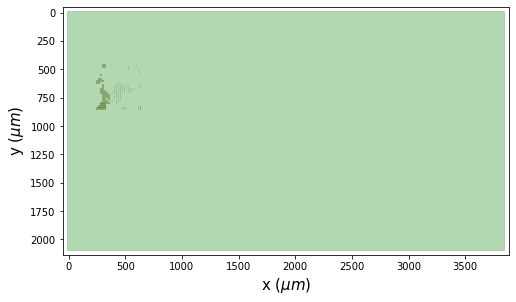

In [10]:
fig, ax = plt.subplots(figsize=(8,8))
si.plot_probe_map(recording_bp, ax=ax, with_channel_ids=False)
ax.invert_yaxis()

# Dirty Method Initial Trials

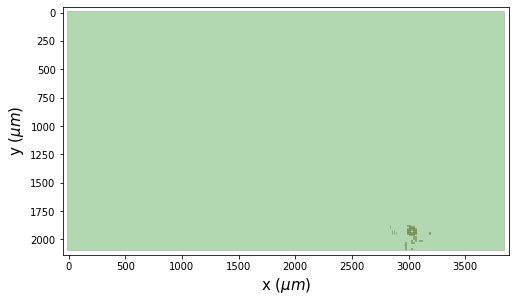

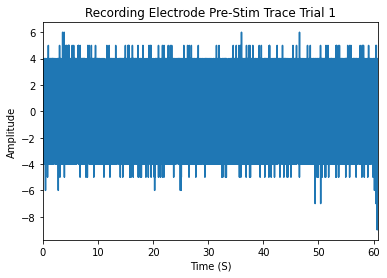

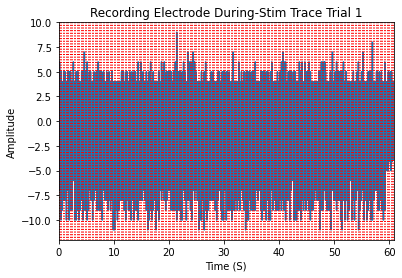

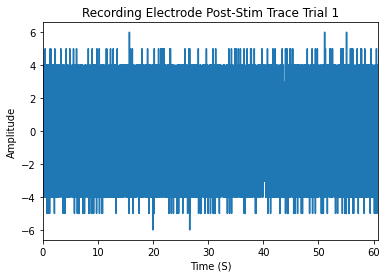

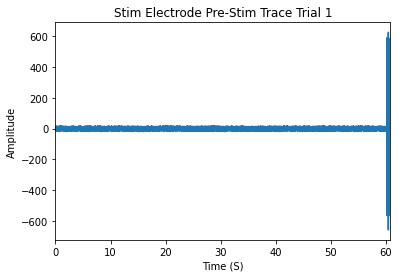

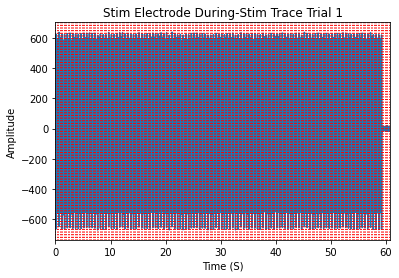

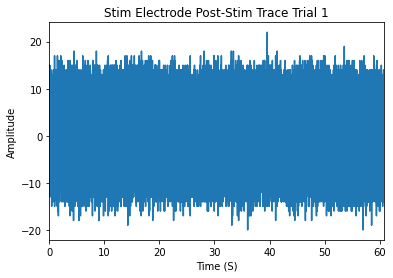

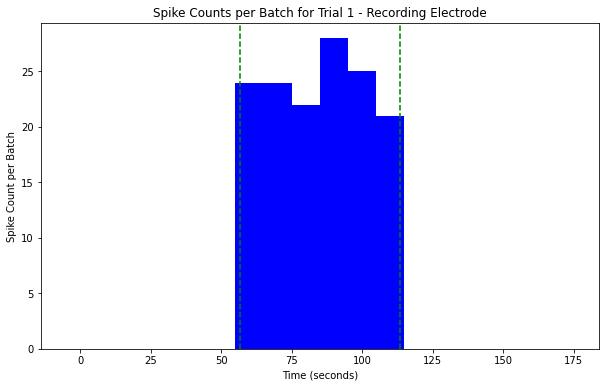

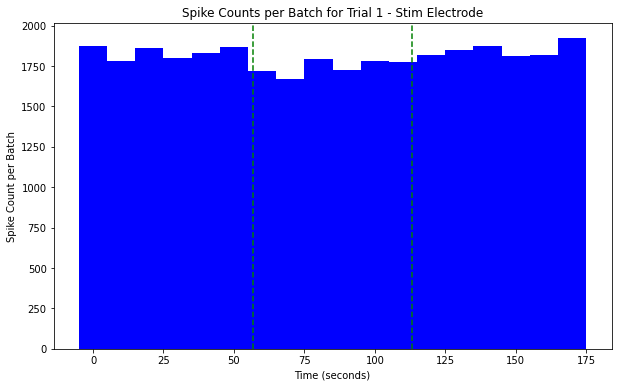

[[-1  3]
 [-1 -2]
 [ 0 -2]
 ...
 [ 0 -1]
 [ 0  0]
 [ 1 -3]]
[ 3 -2 -2 ... -1  0 -3]


IndexError: index 2 is out of bounds for axis 1 with size 2

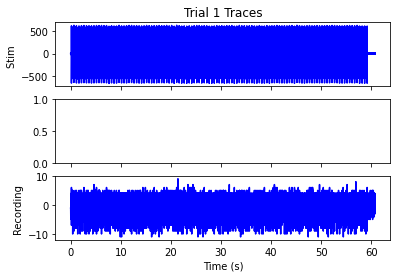

In [161]:
fp = '/mnt/disk15tb/nathaniel/Dirty_Method_N1/000219/data.raw.h5'
full_analysis(fp, 1, recording_electrode=26353, stim_electrode=24592)

